In [2]:
import sys
import subprocess
import json
import os
import platform
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display, HTML

# Hatchet Modeling Example

This is an example for using Hatchet's modeling feature. The modeling capability relies on _Extra-P_ - a tool for empirical performance modeling. It can perform N-parameter modeling with up to 3 parameters (N <= 3). The models follow a so-called _Performance Model Normal Form (PMNF)_ that expresses models as a summation of polynomial and logarithmic terms. One of the biggest advantage of this modeling method is that the produced models are human-readable and easily understandable. The modeling process creates a model out of an array of GraphFrames such that there is a model for row in the dataframe.

## Load Extra-P and Hatchet

In [3]:
# Add package dirs to PYTHONPATH
deploy_dir = "/g/g92/shudler1/projects/modeling/"
sys.path.append(deploy_dir + 'extrap/')   # ver 4.0.3
sys.path.append(deploy_dir + 'hatchet/')  # modified Hatchet (modeling capability)
sys.path.append(deploy_dir + 'Caliper/python/caliper-reader/')

# Add cali-query to PATH
machine = platform.uname().machine
cali_query_path = "/usr/gapps/spot/live/caliper/" + machine + "/bin"
os.environ["PATH"] += os.pathsep + cali_query_path

# Setup cali-query to read SPOT/Caliper files into Hatchet
grouping_attribute = "prop:nested"
default_metric = "avg#inclusive#sum#time.duration"
query = "select %s,sum(%s) group by %s format json-split" % (grouping_attribute, default_metric, grouping_attribute)

import caliperreader as cr
import hatchet as ht

## Define datasets paths and names

In the example, we use datasets from LULESH and Kripke runs that are based on Caliper and HPCToolkit, respectively.

In [37]:
dataset_dir = '/usr/workspace/wsb/asde/hatchet-datasets/sc19-datasets/'

lul_datasets = {
    1: 'lulesh-scaling/lulesh-annotation-profile-1core.json',
    8: 'lulesh-scaling/lulesh-annotation-profile-8cores.json',
    27: 'lulesh-scaling/lulesh-annotation-profile-27cores.json',
    64: 'lulesh-scaling/lulesh-annotation-profile-64cores.json',
    125: 'lulesh-scaling/lulesh-annotation-profile-125cores.json',
    216: 'lulesh-scaling/lulesh-annotation-profile-216cores.json',
    343: 'lulesh-scaling/lulesh-annotation-profile-343cores.json',
    512: 'lulesh-scaling/lulesh-annotation-profile-512cores.json'
}

krip_datasets = {
    64: 'kripke-scaling/hpctoolkit-kripke-database-2589696',
    128: 'kripke-scaling/hpctoolkit-kripke-database-2589460',
    512: 'kripke-scaling/hpctoolkit-kripke-database-2593557',
    2048: 'kripke-scaling/hpctoolkit-kripke-database-2593632'
}

## Load LULESH or Kripke dataset into an array of GraphFrames

In [39]:
which_dataset = 'lulesh'

In [40]:
if which_dataset == 'lulesh':
    core_counts = sorted(lul_datasets.keys())[0:]

    gframes = []
    for c in core_counts:
        gf = ht.GraphFrame.from_caliper_json(dataset_dir + lul_datasets[c])
        gf.drop_index_levels(np.max)
        gframes.append(gf)
elif which_dataset == 'kripke':
    core_counts = sorted(krip_datasets.keys())[0:]

    gframes = []
    for c in core_counts:
        gf = ht.GraphFrame.from_hpctoolkit(dataset_dir + krip_datasets[c])
        gf.drop_index_levels(np.max)
        # Optionally: prune the graph's depth for faster modeling
        gf = gf.filter(lambda x: x['node']._depth <= 3, squash=True)
        gframes.append(gf)
else:
    print('Dataset not supported')

## The first GraphFrame looks as follows

In [41]:
print(gframes[0].tree(depth=4, metric_column="time (inc)"))

    __          __       __         __ 
   / /_  ____ _/ /______/ /_  ___  / /_
  / __ \/ __ `/ __/ ___/ __ \/ _ \/ __/
 / / / / /_/ / /_/ /__/ / / /  __/ /_  
/_/ /_/\__,_/\__/\___/_/ /_/\___/\__/  v1.3.1a0

27339729.000 main
├─ 75.000 MPI_Barrier
├─ 8.000 MPI_Finalize
├─ 41.000 MPI_Reduce
└─ 27279682.000 lulesh.cycle
   ├─ 27276068.000 LagrangeLeapFrog
   │  ├─ 140362.000 CalcTimeConstraintsForElems
   │  ├─ 11082669.000 LagrangeElements
   │  └─ 16052145.000 LagrangeNodal
   └─ 2154.000 TimeIncrement
      └─ 1481.000 MPI_Allreduce

Legend (Metric: time (inc) Min: 8.00 Max: 27339729.00)
█ 24605756.90 - 27339729.00
█ 19137812.70 - 24605756.90
█ 13669868.50 - 19137812.70
█ 8201924.30 - 13669868.50
█ 2733980.10 - 8201924.30
█ 8.00 - 2733980.10

name User code    ◀  Only in left graph    ▶  Only in right graph



## Create models

First, we construct the Modeling object by passing all the relevant data to it. Then, we call `model_all` in that object.

In [42]:
mdl = ht.Modeling(gframes, core_counts, 'cores')
mdl.model_all()

## Models dataframe

In [43]:
mdl.models_df

,time_model,time (inc)_model
node,,
"{'name': 'main', 'type': 'region'}",88369.14285714286,52284570.0
"{'name': 'MPI_Barrier', 'type': 'region'}",5463.142857142857,5463.142857142857
"{'name': 'MPI_Finalize', 'type': 'region'}",134121.57962303315 + 4.461018800035303 * p^(3/...,134121.57962303315 + 4.461018800035303 * p^(3/...
"{'name': 'MPI_Irecv', 'type': 'region'}",563.4285714285714,563.4285714285714
"{'name': 'MPI_Isend', 'type': 'region'}",527.7142857142857,527.7142857142857
"{'name': 'MPI_Reduce', 'type': 'region'}",140348.28571428574,140348.28571428574
"{'name': 'MPI_Wait', 'type': 'region'}",5366.857142857143,5366.857142857143
"{'name': 'MPI_Waitall', 'type': 'region'}",13977.142857142857,13977.142857142857
"{'name': 'lulesh.cycle', 'type': 'region'}",1750.7142857142858,52188382.85714286


## Query specific model

In our example, we want to retrieve a model for `MPI_Allreduce`. It means first finding a GraphNode whose name corresponds to that and then using this node as an index into the dataframe of the models. Note that we look for the desired GraphNode by traversing the modified first GraphFrame in the Modeling object (`mdl.gfs[0].graph`). This is important since the modeling process unifies the graphs and stores them in `mdl.gfs`.

In [44]:
node_list = [n for n in mdl.gfs[0].graph.traverse() if mdl.gfs[0].dataframe.loc[n, 'name'] == 'MPI_Allreduce']
model_exc = mdl.models_df.at[node_list[0], 'time (inc)_model']

## Operations on a model

### Evaluating the model given a value

In [45]:
model_exc.eval(600)

15808333.290517746

### Displaying the model

It returns a _figure_ and an _axis_ objects. The axis object can be used to adjust the plot, i.e., change labels.

In [46]:
fig, ax = model_exc.display()

Explicitly ask Matplotlib to show figures:

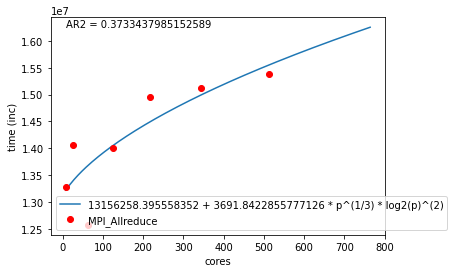

In [47]:
plt.show()

## Show the models dataframe with embedded plots

,time_model,time (inc)_model
node,,
"{'name': 'main', 'type': 'region'}",,
"{'name': 'MPI_Barrier', 'type': 'region'}",,
"{'name': 'MPI_Finalize', 'type': 'region'}",,
"{'name': 'MPI_Irecv', 'type': 'region'}",,
"{'name': 'MPI_Isend', 'type': 'region'}",,
"{'name': 'MPI_Reduce', 'type': 'region'}",,
"{'name': 'MPI_Wait', 'type': 'region'}",,
"{'name': 'MPI_Waitall', 'type': 'region'}",,
"{'name': 'lulesh.cycle', 'type': 'region'}",,

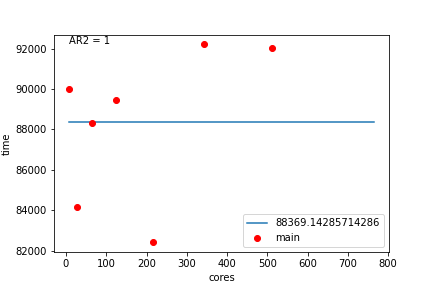
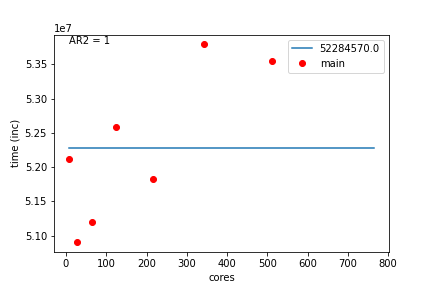
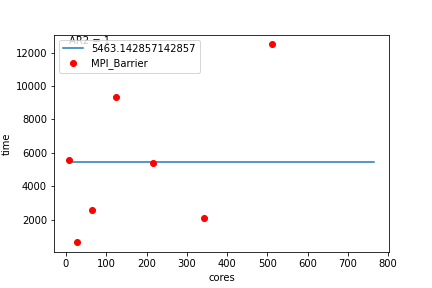
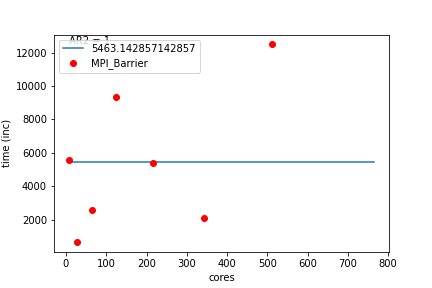
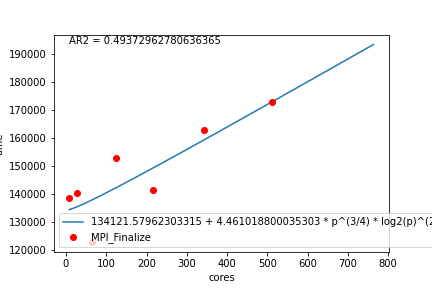
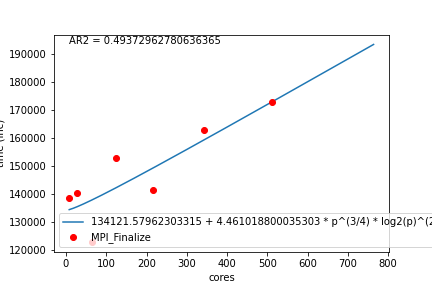
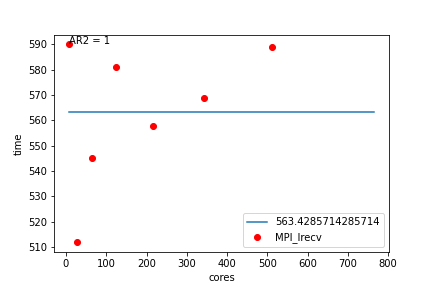
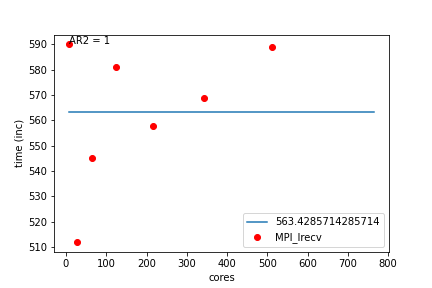
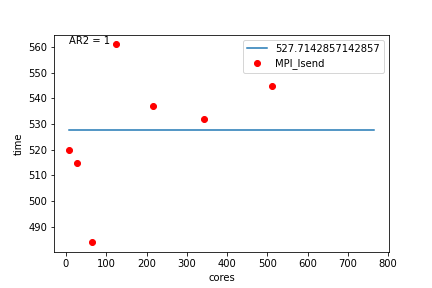
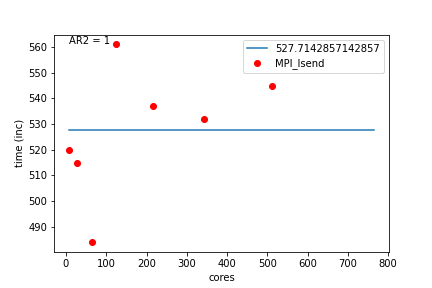
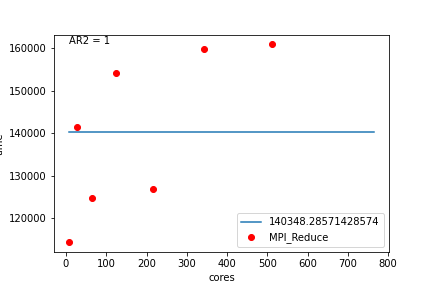
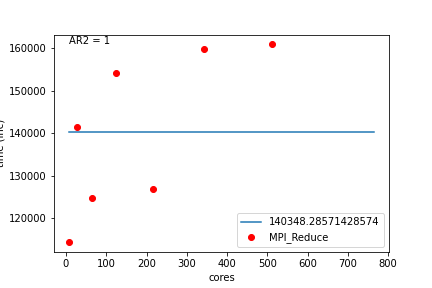
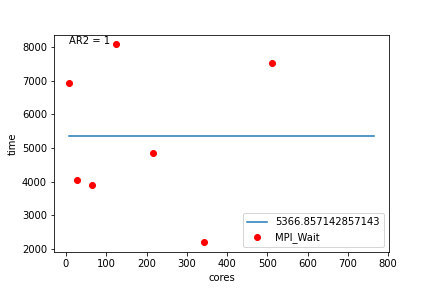
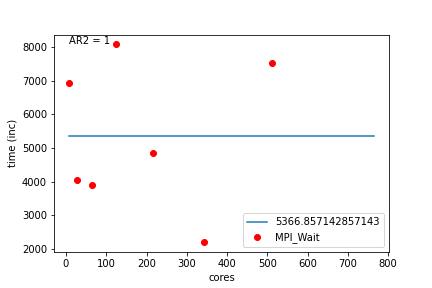
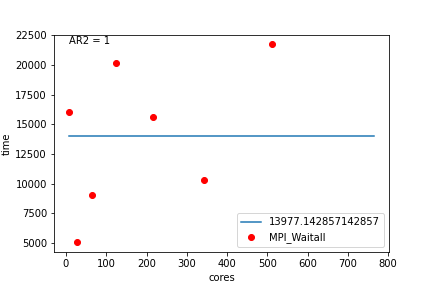
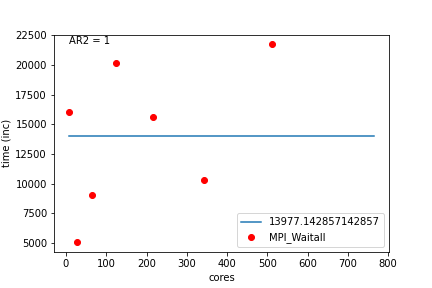
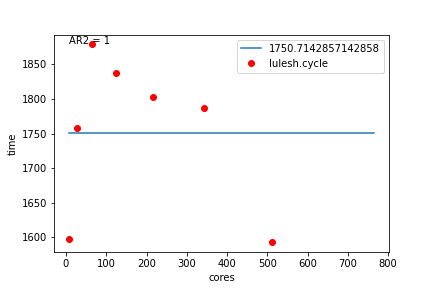
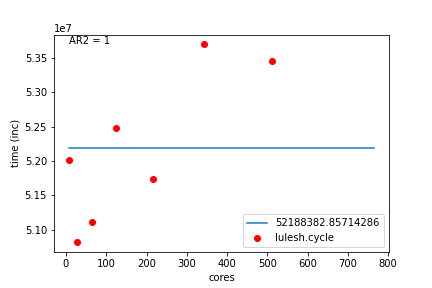
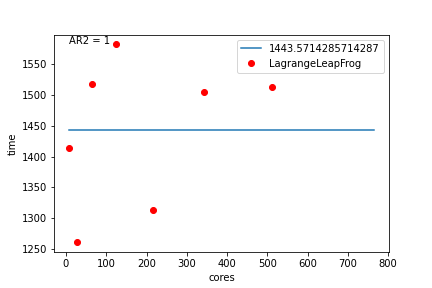
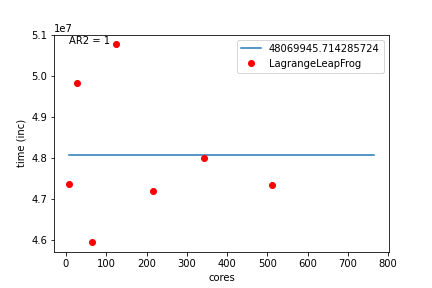
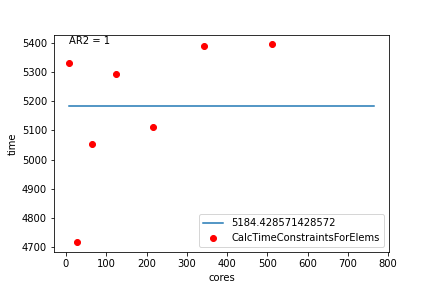
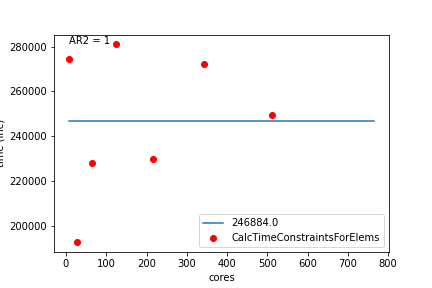
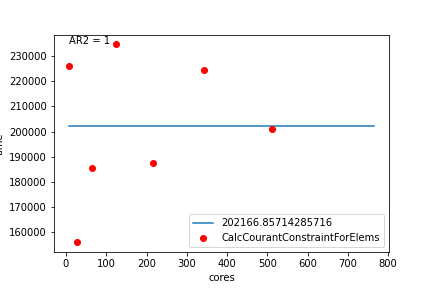
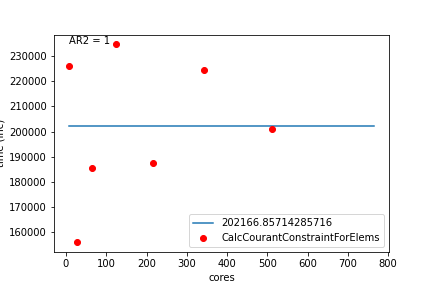
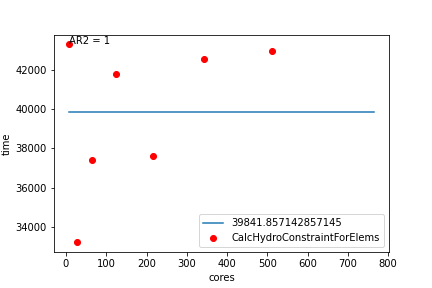
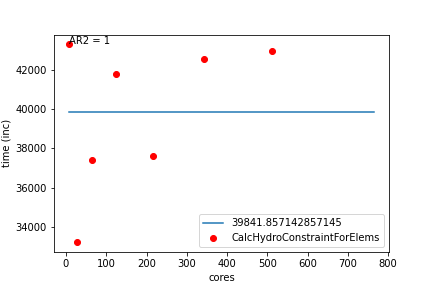
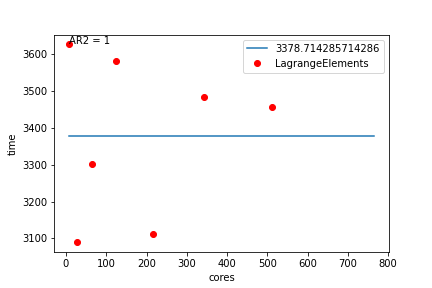
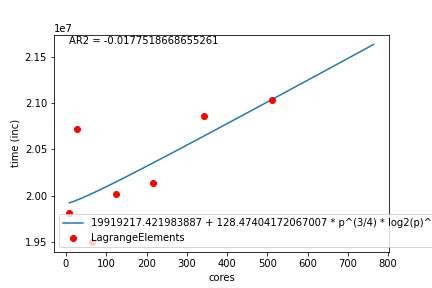
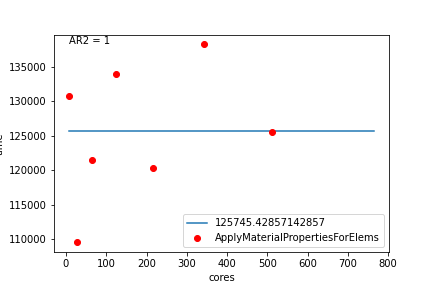
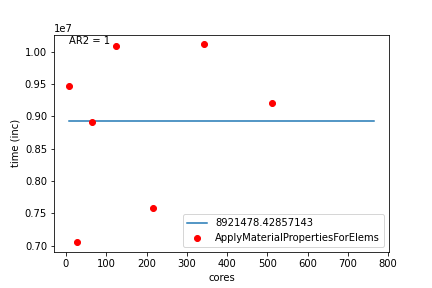
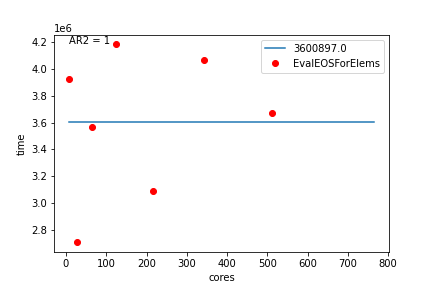
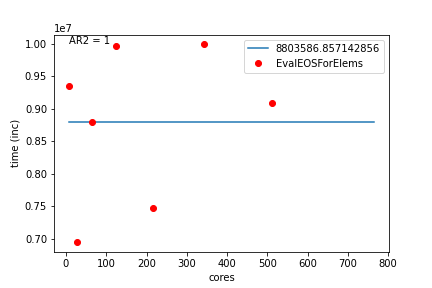
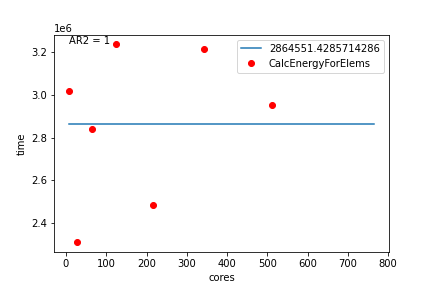
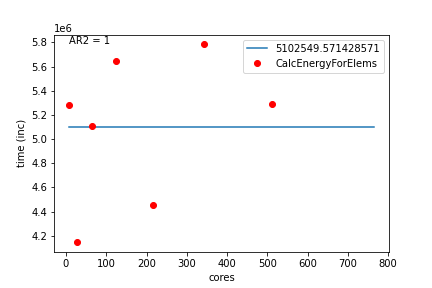
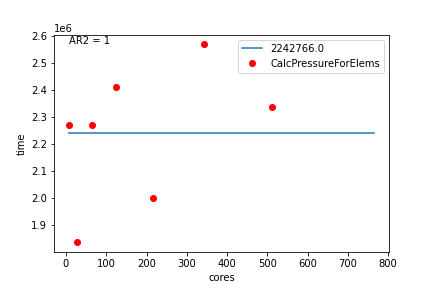
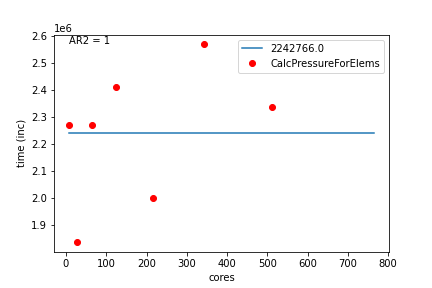
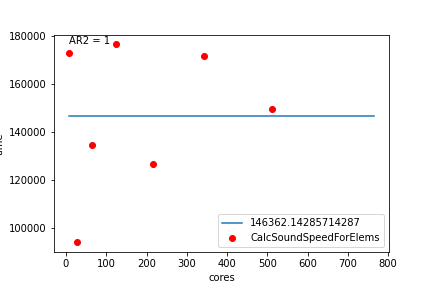
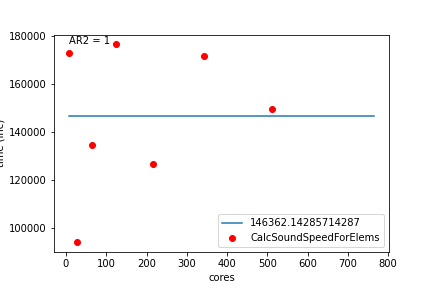
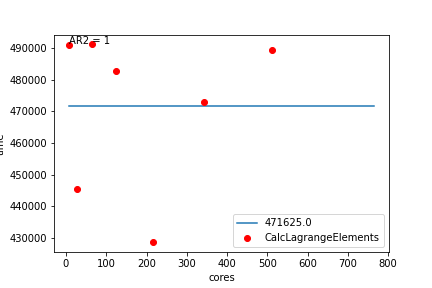
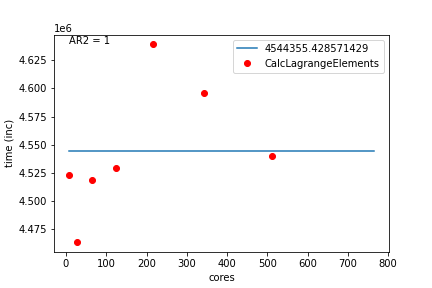
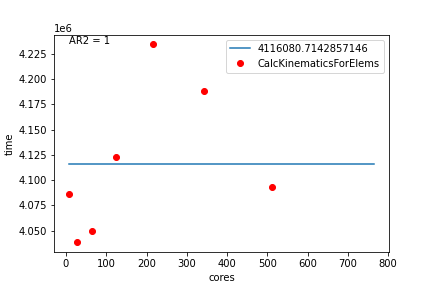
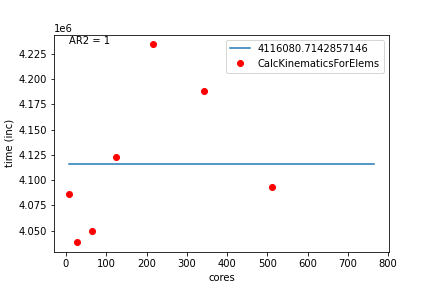
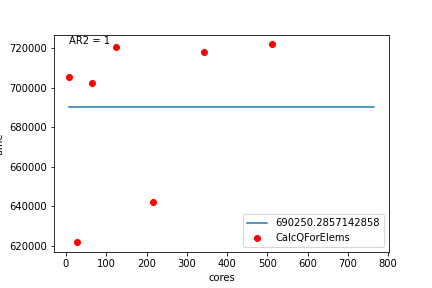
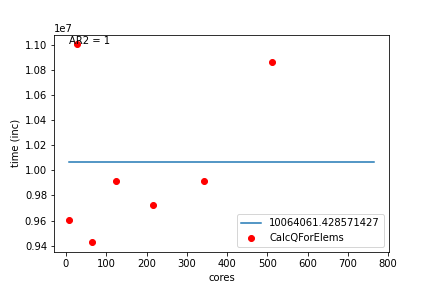
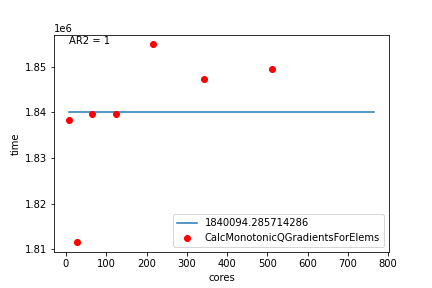
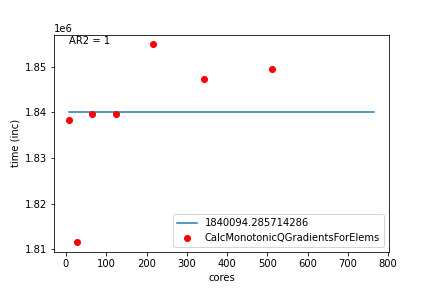
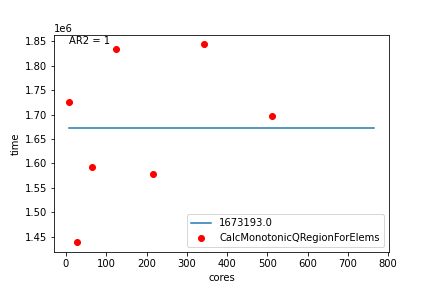
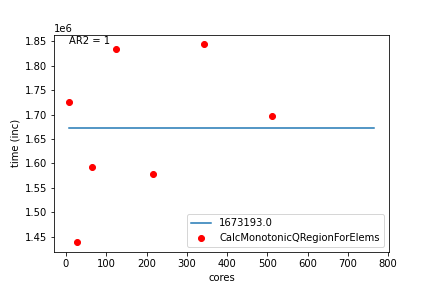
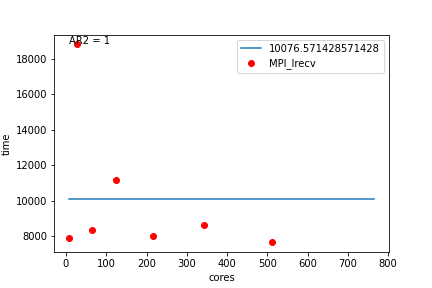
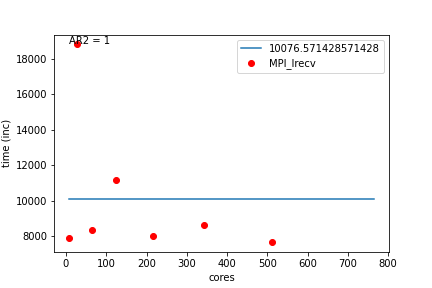
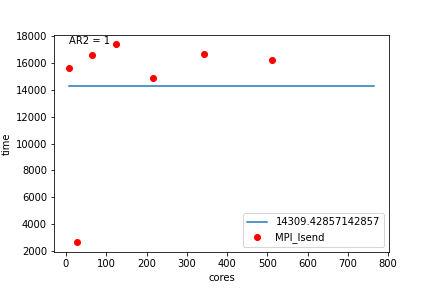
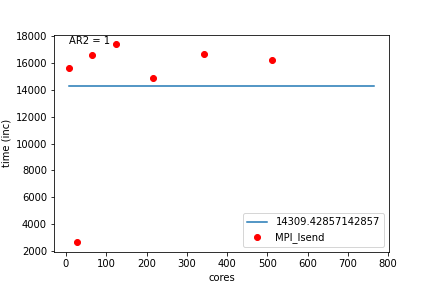
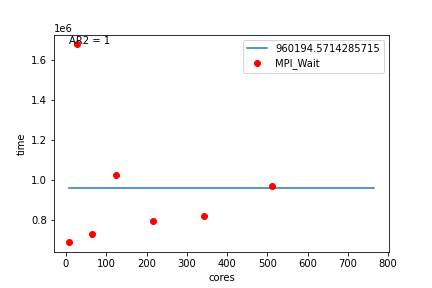
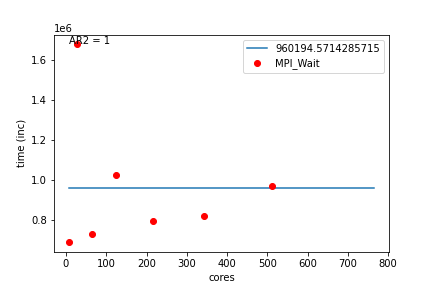
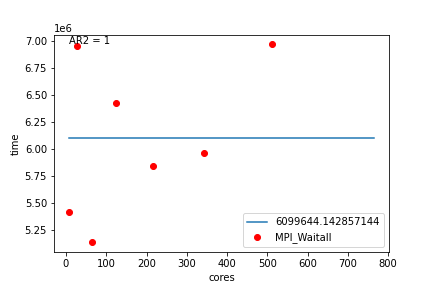
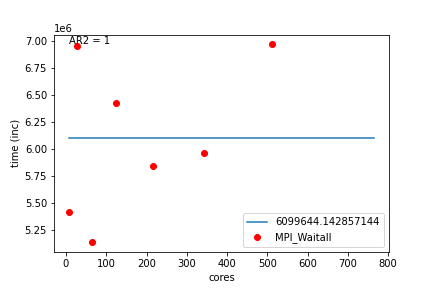
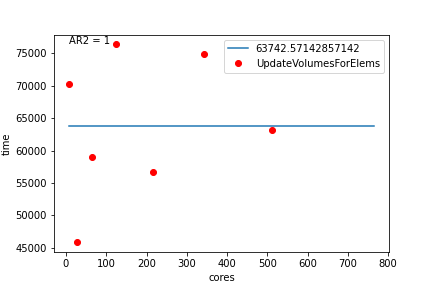
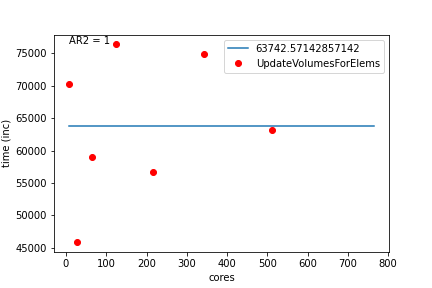
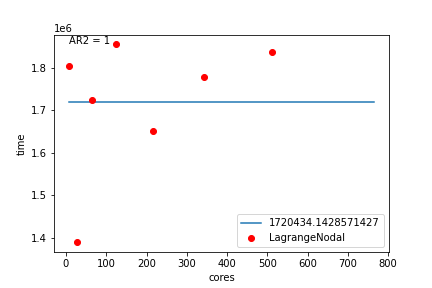
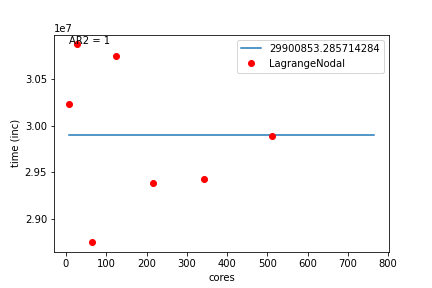
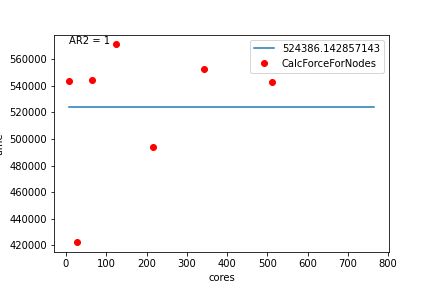
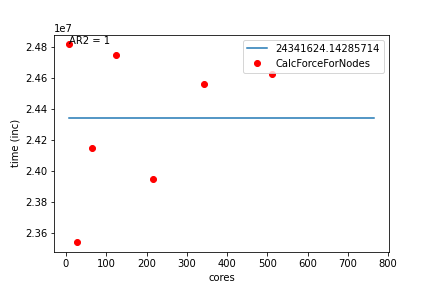
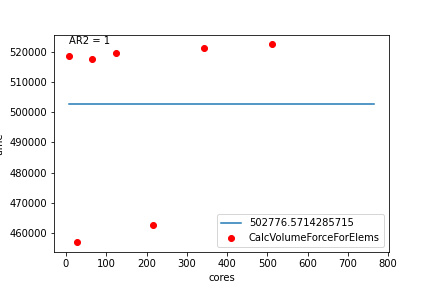
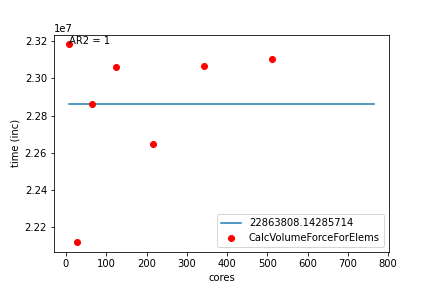
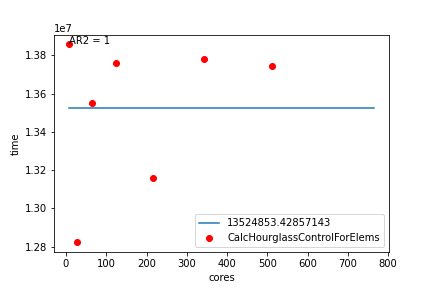
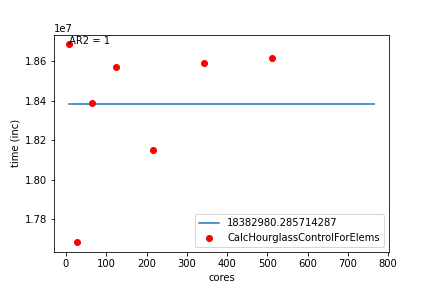
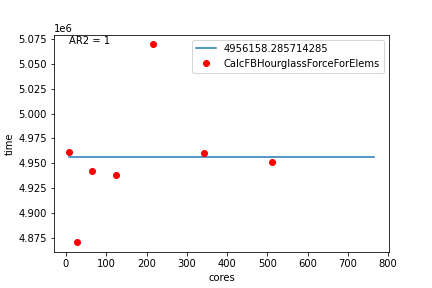
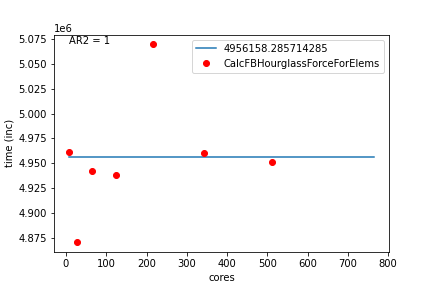
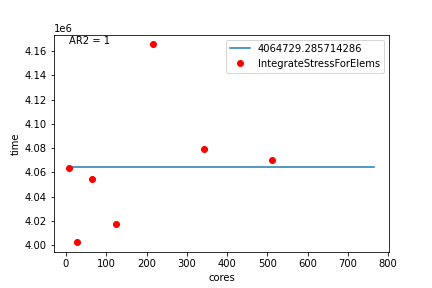
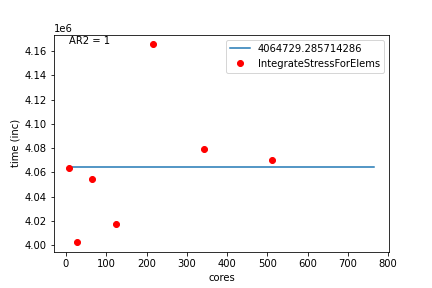
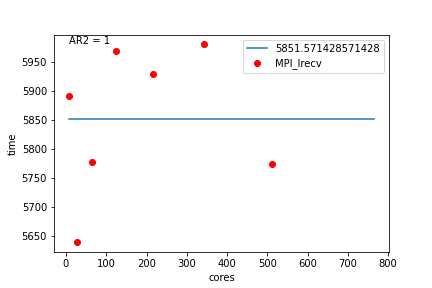
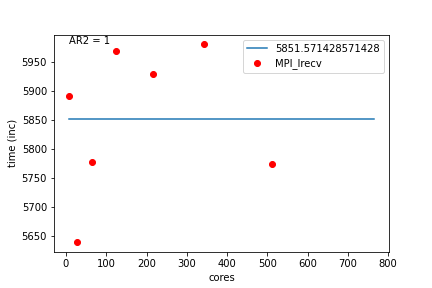
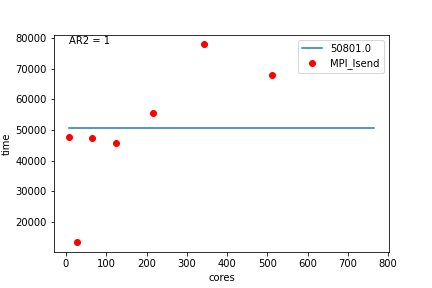
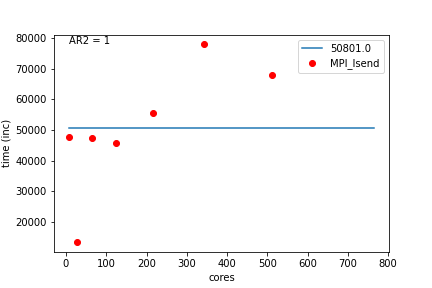
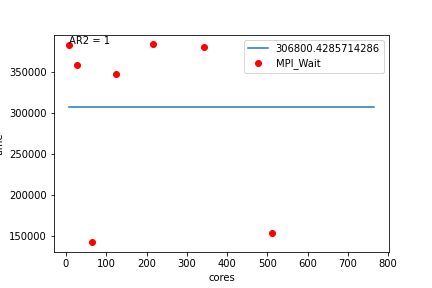
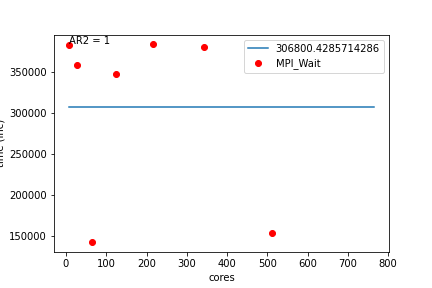
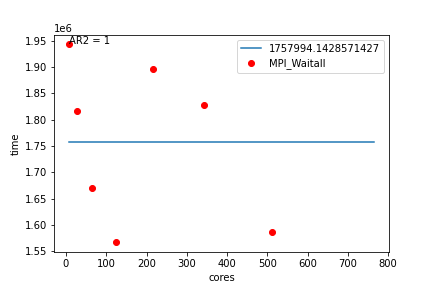
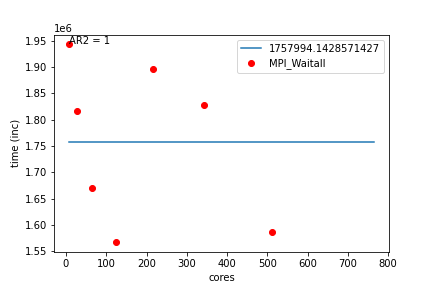
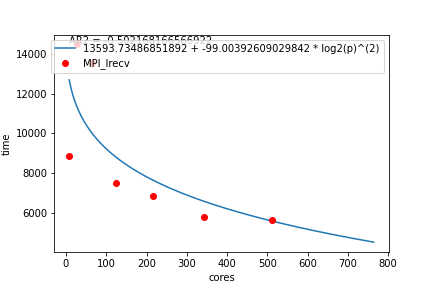
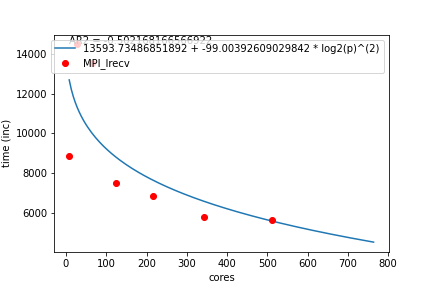
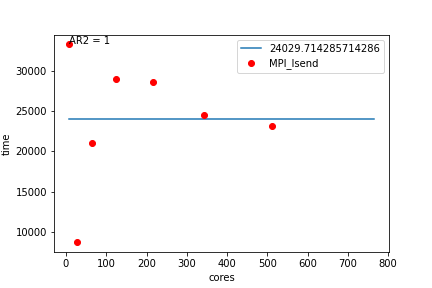
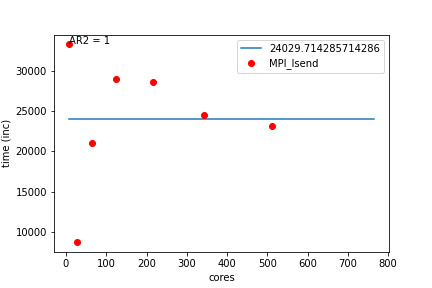
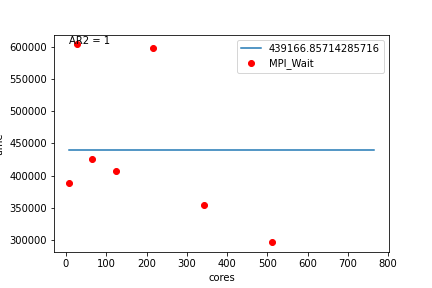
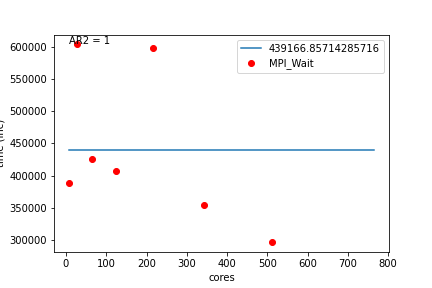
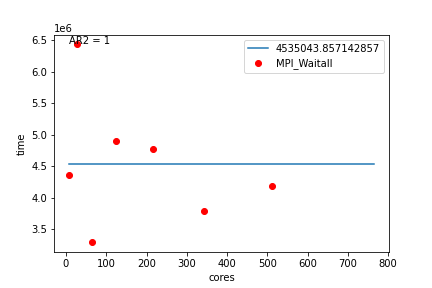
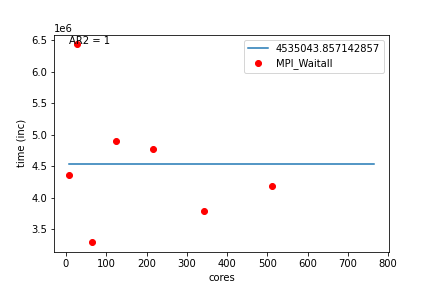
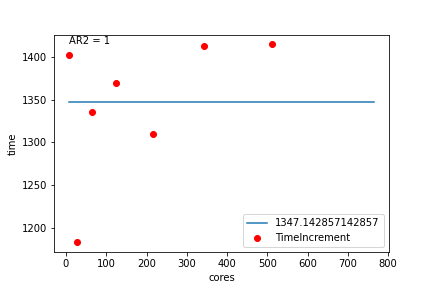
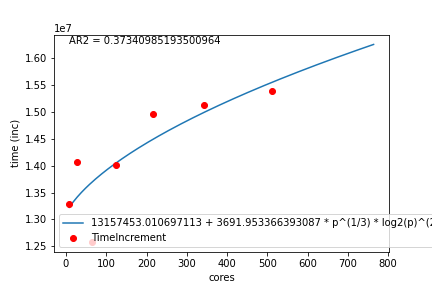
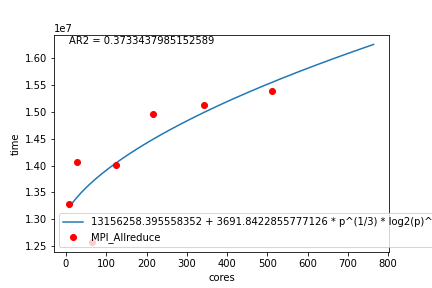
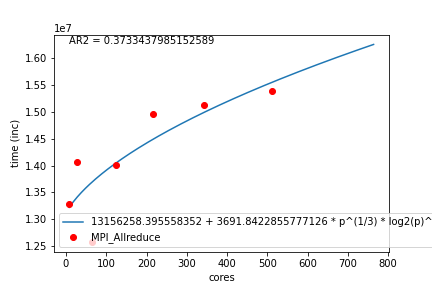

In [48]:
with pd.option_context('display.max_colwidth', -1):
    display(HTML(mdl.to_html()))

## Using different parameters for modeling

In the example below we read Caliper files with meta data that includes the number of processes (i.e., job size) and input size (i.e. problem size). We can then use either of these two parameters as a modeling parameter.

In [14]:
datasets = glob.glob(deploy_dir + 'spotbe/demos/mpi/*.cali')
dsmap = {}
for ds in datasets:
    globs = cr.read_caliper_globals(ds)
    jobsz = int(globs['jobsize'])
    probsz = int(globs['problem_size'])
    if jobsz not in dsmap:
        dsmap[jobsz] = {}
    dsmap[jobsz][probsz] = ds

In [18]:
jsizes = sorted(dsmap.keys())
psizes = sorted(dsmap[jsizes[1]])
jsizes, psizes

([27, 64, 125, 216, 343], [10, 20, 30, 40, 50])

Fixing the number of processes to 64 (`jsizes[1]`) and reading the GraphFrames for increasing problem size (i.e., 10, 20, 30, 40, 50):

In [19]:
gframes = []
# for j in jsizes:
#     gf = ht.GraphFrame.from_caliper(dsmap[j][psizes[0]], query)
#     gframes.append(gf)
for probsz in psizes:
    gf = ht.GraphFrame.from_caliper(dsmap[jsizes[1]][probsz], query)
    gframes.append(gf)

In [20]:
mdl = ht.Modeling(gframes, psizes, 'problem size')
mdl.model_all()

,time (inc)_model
node,
"{'name': 'MPI_Allreduce', 'type': 'region'}",
"{'name': 'MPI_Bcast', 'type': 'region'}",
"{'name': 'MPI_Comm_dup', 'type': 'region'}",
"{'name': 'MPI_Comm_free', 'type': 'region'}",
"{'name': 'MPI_Comm_split', 'type': 'region'}",
"{'name': 'MPI_Gather', 'type': 'region'}",
"{'name': 'MPI_Initialized', 'type': 'region'}",
"{'name': 'main', 'type': 'region'}",
"{'name': 'MPI_Barrier', 'type': 'region'}",

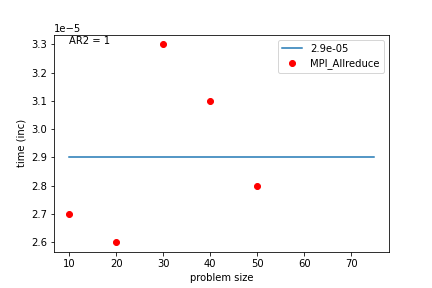
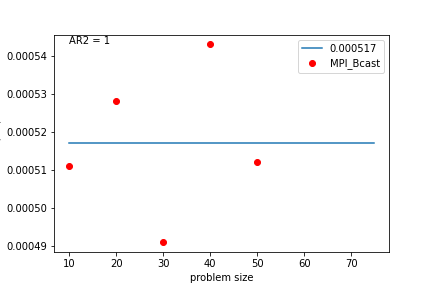
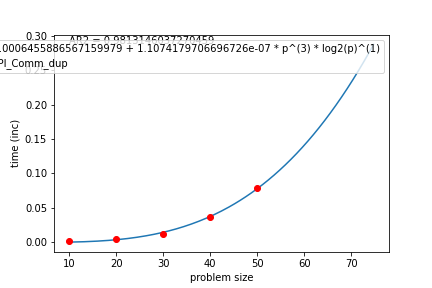
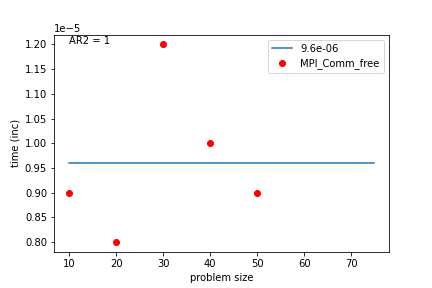
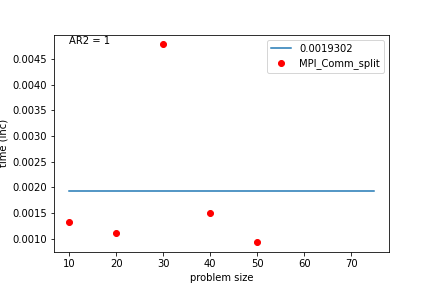
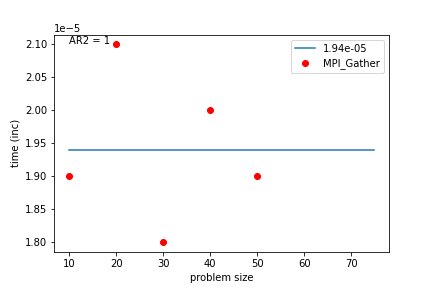
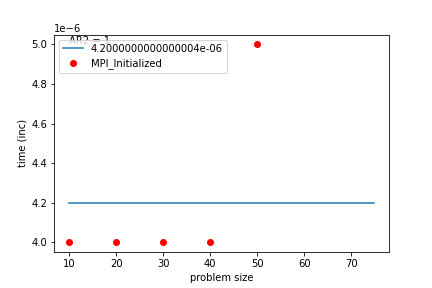
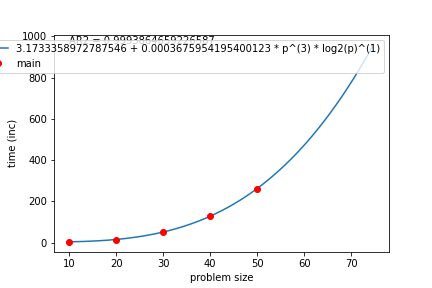
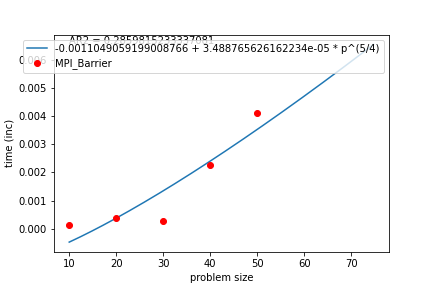
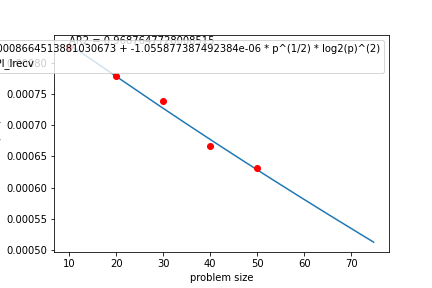
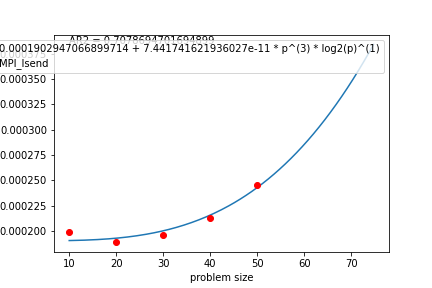
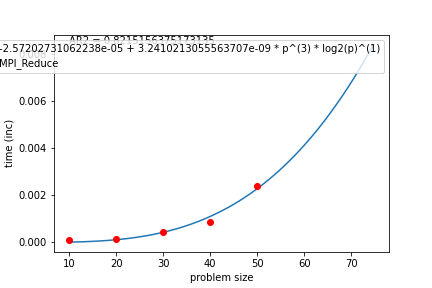
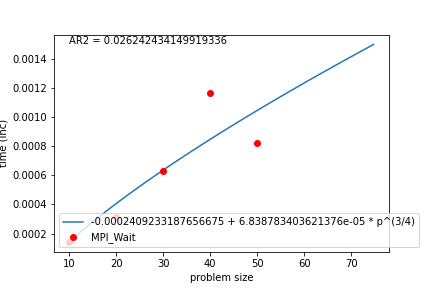
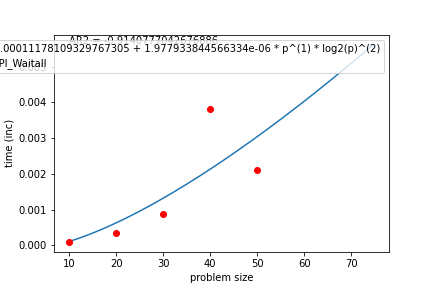
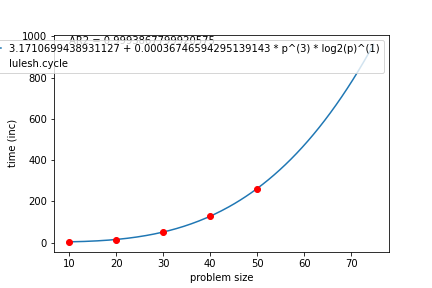
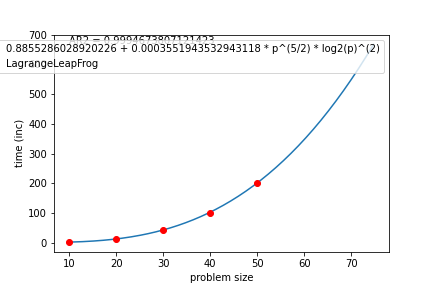
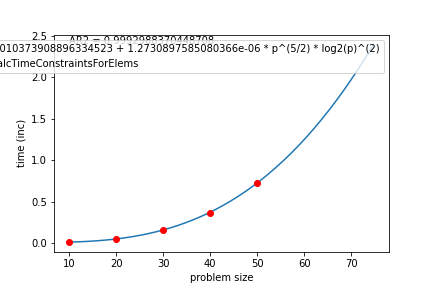
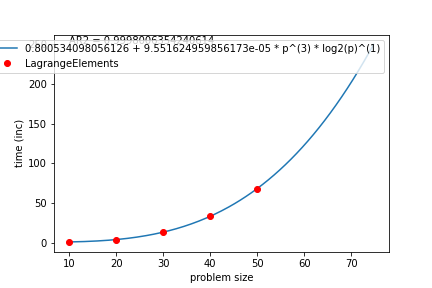
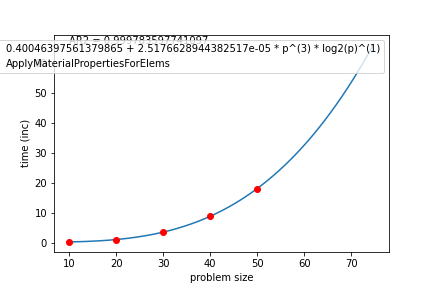
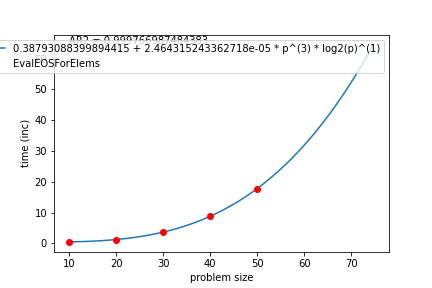
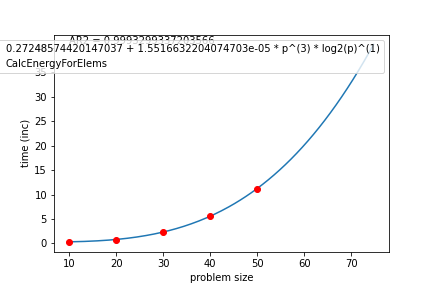
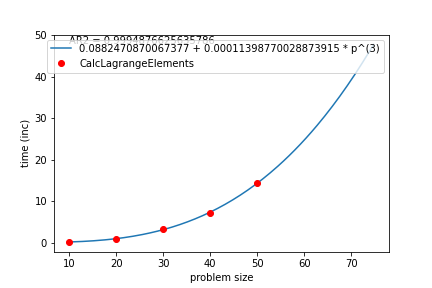
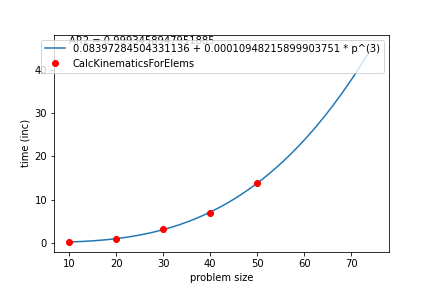
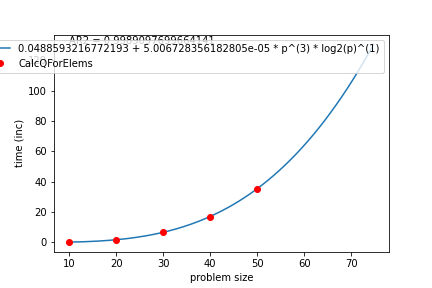
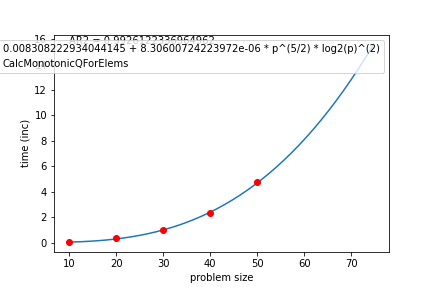
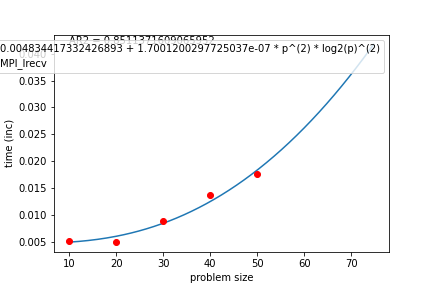
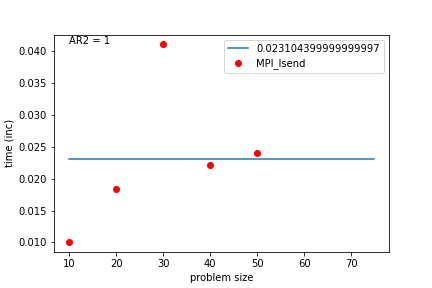
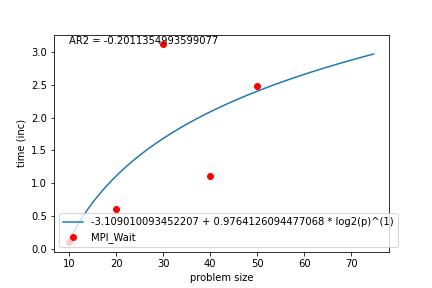
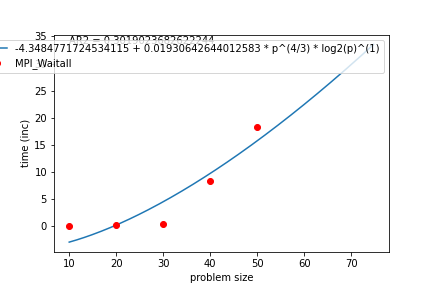
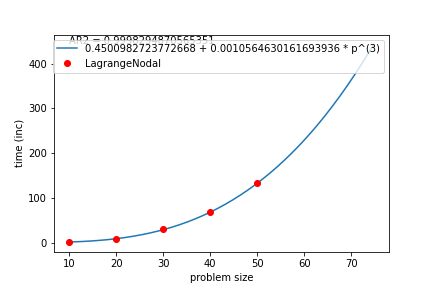
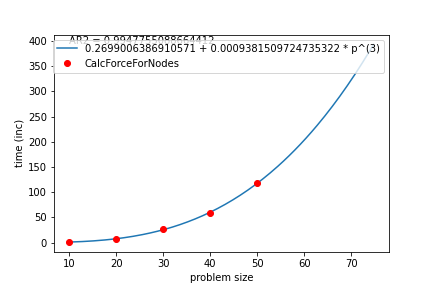
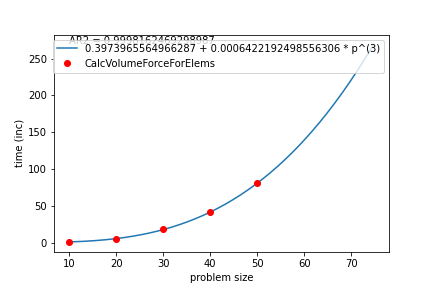
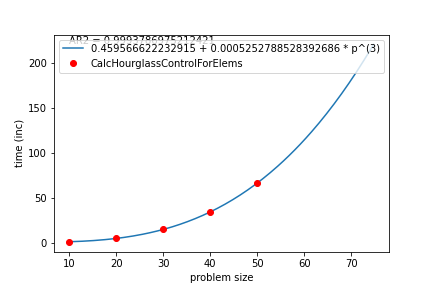
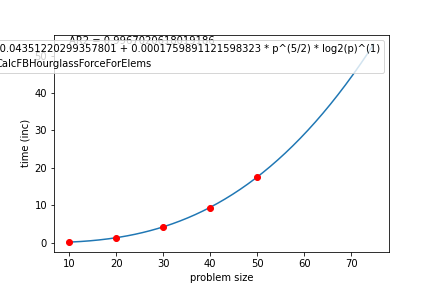
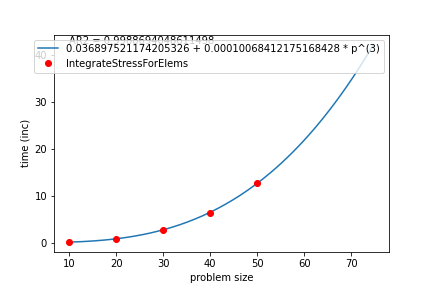
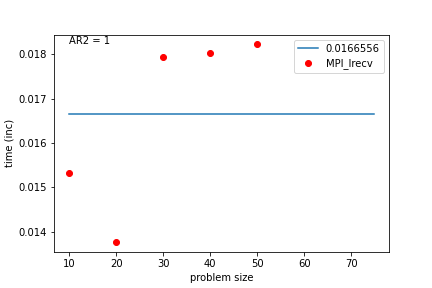
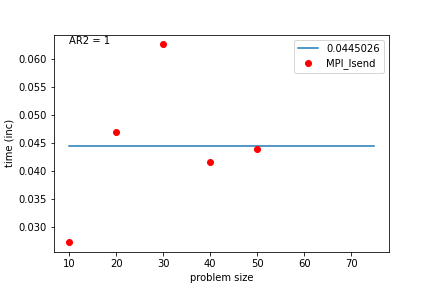
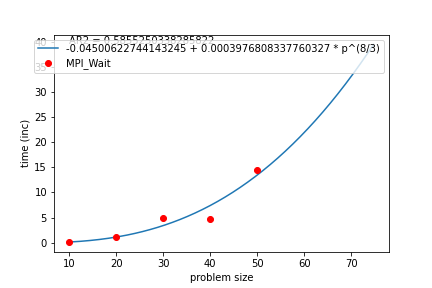
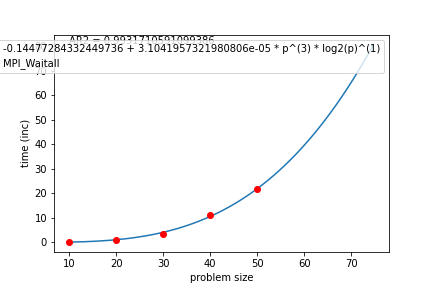
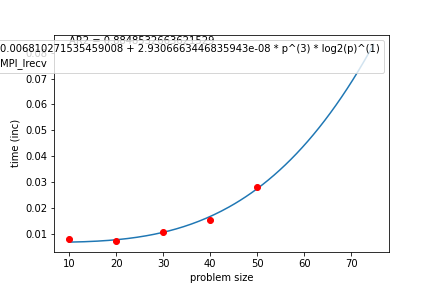
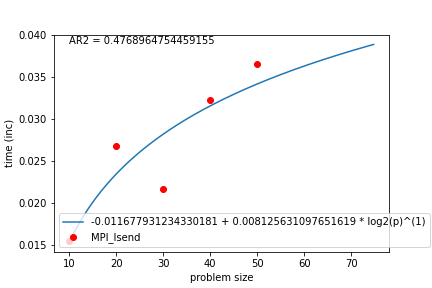
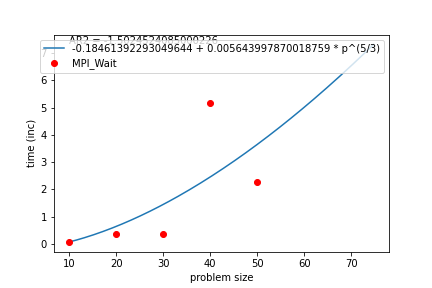
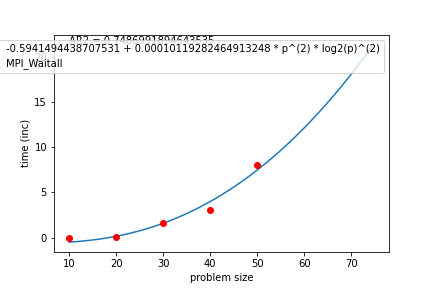
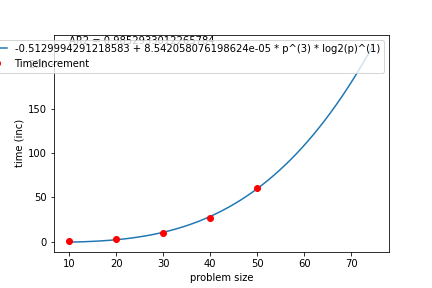
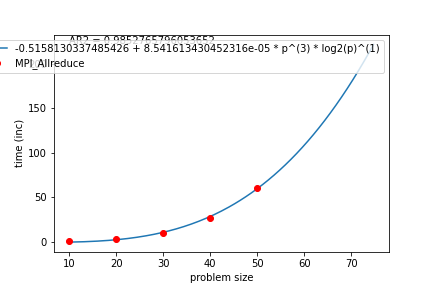

In [21]:
with pd.option_context('display.max_colwidth', -1):
    display(HTML(mdl.to_html()))